In [1]:
%matplotlib inline
import numpy as np
# Region of interest where in the CSD lies
# It is not necessarily the same place where the electrodes are placed 
# This can be a region of the brain or a slice area
csd_at = np.mgrid[0.:1.:100j,                                                                                                                                                           
                  0.:1.:100j]
csd_x, csd_y = csd_at

In [2]:
# Now lets place a CSD profile in this region
# Some default CSD profiles are already defined here
# We shall also plot to see how this looks like
from kcsd import csd_profile as CSD

CSD_PROFILE = CSD.gauss_2d_small
true_csd = CSD_PROFILE(csd_at, seed=5) 
# You can try a different seed - which will give you a different True CSD

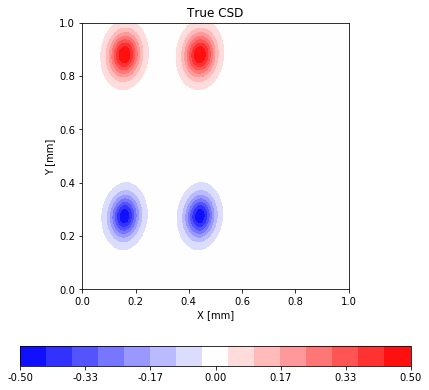

In [3]:
# Lets try and see how this True CSD looks like
import matplotlib.pyplot as plt
import matplotlib.cm as cm


fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_aspect('equal')
t_max = np.max(np.abs(true_csd))
levels = np.linspace(-1 * t_max, t_max, 16)
im = ax.contourf(csd_x, csd_y, true_csd, levels=levels, cmap=cm.bwr)
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title('True CSD')
ticks = np.linspace(-1 * t_max, t_max, 7, endpoint=True)
plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)

In [4]:
# Now lets place some electrodes over this brain slice
ele_x, ele_y = np.mgrid[0.1: 0.9: 10j,
                        0.1: 0.9: 10j]
ele_pos = np.vstack((ele_x.flatten(), ele_y.flatten())).T

In [5]:
from scipy.integrate import simps
from scipy.interpolate import griddata

def integrate_2d(csd_at, true_csd, ele_pos, h, csd_lims):
    csd_x, csd_y = csd_at
    xlin = csd_lims[0]                                                                                                                                                                                      
    ylin = csd_lims[1]                                                                                                                                                                                      
    Ny = ylin.shape[0]                                                                                                                                                                                      
    m = np.sqrt((ele_pos[0] - csd_x)**2 + (ele_pos[1] - csd_y)**2)  # construct 2-D integrand                                                                                                               
    m[m < 0.0000001] = 0.0000001
    y = np.arcsinh(2 * h / m) * true_csd
    integral_1D = np.zeros(Ny)                                        
    for i in range(Ny):                                                  
        integral_1D[i] = simps(y[:, i], ylin)
    integral = simps(integral_1D, xlin)
    return integral

def grid(x, y, z):                                                                                                                                                                    
    x = x.flatten()                                                                                                                                                                                             
    y = y.flatten()                                                                                                                                                                                             
    z = z.flatten()                                                                                                                                                                                             
    xi, yi = np.mgrid[min(x):max(x):np.complex(0, 100),                                                                                                                                                        
                      min(y):max(y):np.complex(0, 100)]                                                                                                                                                        
    zi = griddata((x, y), z, (xi, yi), method='linear')                                                                                                                                                         
    return xi, yi, zi

In [6]:
# Lets compute the potentials generated at these electrode positions
pots = np.zeros(ele_pos.shape[0])
xlin = csd_at[0, :, 0]
ylin = csd_at[1, 0, :]
h = 50.  # distance between the electrode plane and the CSD plane
sigma = 0.3 # S/m
for ii in range(ele_pos.shape[0]):                                                                                                                                                                      
    pots[ii] = integrate_2d(csd_at, true_csd,                                                                                                                                                         
                            [ele_pos[ii][0], ele_pos[ii][1]], h,                                                                                                                                      
                            [xlin, ylin])
pots /= 2 * np.pi * sigma
pot_X, pot_Y, pot_Z = grid(ele_pos[:, 0], ele_pos[:, 1], pots)

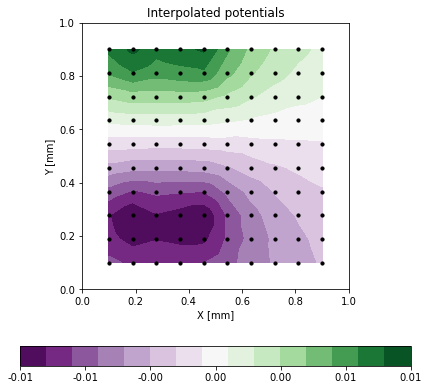

In [7]:
# The potentials for this configuration is now ploted in the same plane
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
ax.set_aspect('equal')
v_max = np.max(np.abs(pots))
levels_pot = np.linspace(-1 * v_max, v_max, 16)
im = ax.contourf(pot_X, pot_Y, pot_Z, levels=levels_pot, cmap=cm.PRGn) 
ax.scatter(ele_pos[:, 0], ele_pos[:, 1], 10, c='k')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title('Interpolated potentials')
ticks = np.linspace(-1 * v_max, v_max, 7, endpoint=True)                                                                                                                                                    
plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)

In [8]:
# Lets compute the KCSD using the method
from kcsd import KCSD2D

pots = pots.reshape((len(ele_pos), 1)) # Time points
k = KCSD2D(ele_pos, pots, h=h, sigma=sigma,                                                                                                                                                       
           xmin=0.0, xmax=1.0,
           ymin=0.0, ymax=1.0,
           n_src_init=1000, src_type='gauss')   # rest of the parameters are set at default
est_csd = k.values('CSD')

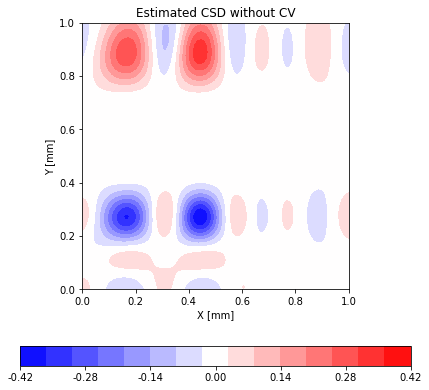

In [9]:
# Lets make a plot of the estimated CSD
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
ax.set_aspect('equal')
t_max = np.max(np.abs(est_csd[:, :, 0]))
levels_kcsd = np.linspace(-1 * t_max, t_max, 16, endpoint=True)
im = ax.contourf(k.estm_x, k.estm_y, est_csd[:, :, 0], levels=levels_kcsd, cmap=cm.bwr) 
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title('Estimated CSD without CV')
ticks = np.linspace(-1 * t_max, t_max, 7, endpoint=True)                                                                                                                                                    
plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)

In [10]:
k.cross_validate(lambdas=None, Rs=np.arange(0.03, 0.05, 0.005))

No lambda given, using defaults
Cross validating R (all lambda) : 0.03
Cross validating R (all lambda) : 0.035
Cross validating R (all lambda) : 0.04
Cross validating R (all lambda) : 0.045
Cross validating R (all lambda) : 0.05
R, lambda : 0.05 6.81292069058e-22


(0.049999999999999989, 6.812920690579594e-22)

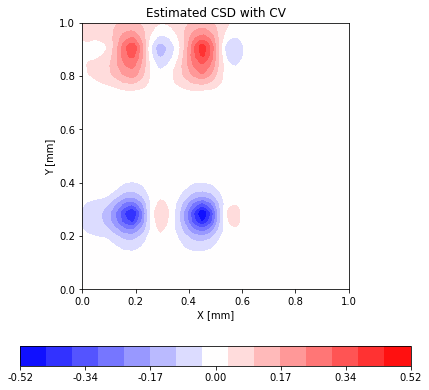

In [11]:
est_csd = k.values('CSD')
# Lets make a plot of the estimated CSD
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
ax.set_aspect('equal')
t_max = np.max(np.abs(est_csd[:, :, 0]))
levels_kcsd = np.linspace(-1 * t_max, t_max, 16, endpoint=True)
im = ax.contourf(k.estm_x, k.estm_y, est_csd[:, :, 0], levels=levels_kcsd, cmap=cm.bwr) 
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title('Estimated CSD with CV')
ticks = np.linspace(-1 * t_max, t_max, 7, endpoint=True)                                                                                                                                                    
plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)

In [ ]:
# In oder to simplify this we developed as validation class
# Which processes all these inputs in one go and gives output
from kcsd import ValidateKCSD2D

params = {true_csd_xlims : [0., 1.],
          true_csd_ylims : [0., 1.],
          csd_xres : 100, csd_yres : 100, 
          h : 50., sigma=0.3, n_srcs_init=1000}
#                      csd_seed : 5,
#          ele_xlims : [0.1, 0.9],
#          ele_ylims : [0.1, 0.9],
#            src_type='gauss', 
#             h =50., sigma=0.3, n_src_init=1000, }

v = ValidateKCSD2D(CSD_SEED, h=50., sigma=0.3, n_src_init=1000)